## Importing Relevant Libraries

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import matplotlib.dates as mdates
from tqdm import tqdm 

## Loading The Data

In [4]:
futures_df = pd.read_csv('trb_usdt_futures_export.csv', parse_dates=['time'])
spot_df = pd.read_csv('trb_usdt_spot_export.csv', parse_dates=['time'])
trades_df = pd.read_csv('trb_usdt_trades_export.csv', parse_dates=['time'])

## Viewing the Data

In [5]:
futures_df.head()

,time,symbol,bid_price,ask_price
0,2025-05-28 11:48:50.593+00,TRB_USDT,50.537,50.538
1,2025-05-28 11:48:50.571+00,TRB_USDT,50.537,50.540
2,2025-05-28 11:48:50.562+00,TRB_USDT,50.537,50.541
3,2025-05-28 11:48:50.554+00,TRB_USDT,50.537,50.542
4,2025-05-28 11:48:50.551+00,TRB_USDT,50.537,50.544


In [6]:
spot_df.head()

,time,symbol,bid_price,ask_price
0,2025-05-28 11:48:51.391000+00:00,TRB_USDT,50.57,50.58
1,2025-05-28 11:48:51.334000+00:00,TRB_USDT,50.56,50.58
2,2025-05-28 11:48:51.198000+00:00,TRB_USDT,50.57,50.58
3,2025-05-28 11:48:51.193000+00:00,TRB_USDT,50.56,50.58
4,2025-05-28 11:48:50.829000+00:00,TRB_USDT,50.56,50.57


In [7]:
trades_df.head()

,time,symbol,price,quantity,is_market_maker
0,2025-05-28 11:48:48.377+00,TRB_USDT,50.56,0.200,t
1,2025-05-28 11:48:45.095+00,TRB_USDT,50.55,4.395,t
2,2025-05-28 11:48:45.095+00,TRB_USDT,50.54,5.600,t
3,2025-05-28 11:48:44.298+00,TRB_USDT,50.56,6.750,t
4,2025-05-28 11:48:44.298+00,TRB_USDT,50.57,6.750,t


## Sorting The Data with Respect to Time

In [8]:
futures_df.sort_values('time', inplace=True)
spot_df.sort_values('time', inplace=True)
trades_df.sort_values('time', inplace=True)

## Adding The Column for Mid-Price

In [9]:
futures_df['mid_price'] = (futures_df['bid_price'] + futures_df['ask_price']) / 2
spot_df['mid_price'] = (spot_df['bid_price'] + spot_df['ask_price']) / 2

## Taking Care of mixed datetime formats (Some entries include microseconds e.g. 14:33:03.815000+00:00 & Some don’t e.g. 14:38:58+00:00)

In [10]:
spot_df['time'] = pd.to_datetime(spot_df['time'], format='mixed', utc=True)
futures_df['time'] = pd.to_datetime(futures_df['time'], format='mixed', utc=True)
trades_df['time'] = pd.to_datetime(trades_df['time'], format='mixed', utc=True)

## Detecting Sudden Moves ("tqdm" is used to monitor progress because it was taking time to run)

In [11]:
def detect_sudden_moves(df, time_col='time', price_col='mid_price', window_ms=3, threshold_bps=7):
    sudden_moves = []
    for i in tqdm(range(1, len(df)), desc="Detecting Sudden Moves"):
        t_now = df.iloc[i][time_col]
        if isinstance(t_now, str):
            t_now = pd.to_datetime(t_now)
        t_past = t_now - pd.Timedelta(milliseconds=window_ms)

        prev_rows = df[(df[time_col] < t_now) & (df[time_col] >= t_past)]

        if not prev_rows.empty:
            last_price = prev_rows.iloc[-1][price_col]
            current_price = df.iloc[i][price_col]
            delta_pct = (current_price - last_price) / last_price * 10000

            if abs(delta_pct) >= threshold_bps:
                sudden_moves.append({
                    'time': t_now,
                    'price_now': current_price,
                    'price_prev': last_price,
                    'delta_bps': delta_pct
                })
    return pd.DataFrame(sudden_moves)

In [12]:
sudden_moves_spot = detect_sudden_moves(spot_df)
sudden_moves_futures = detect_sudden_moves(futures_df)

Detecting Sudden Moves: 100%|██████████| 1048574/1048574 [1:46:59<00:00, 163.33it/s] 


## Below is the Data for sudden moves in Spot & Futures

In [13]:
sudden_moves_spot.head()

,time,price_now,price_prev,delta_bps
0,2025-05-27 14:39:23.698000+00:00,44.415,44.380,7.886435
1,2025-05-27 14:39:23.702000+00:00,44.450,44.415,7.880221
2,2025-05-27 14:40:30.915000+00:00,44.825,44.790,7.814244
3,2025-05-27 14:40:30.915000+00:00,44.855,44.790,14.512168
4,2025-05-27 14:40:30.915000+00:00,44.835,44.790,10.046885


In [14]:
sudden_moves_futures.head()

,time,price_now,price_prev,delta_bps
0,2025-05-28 04:21:53.029000+00:00,50.8445,50.8075,7.282389
1,2025-05-28 04:21:53.029000+00:00,50.8450,50.8075,7.380800
2,2025-05-28 04:22:14.051000+00:00,51.0730,51.0320,8.034175
3,2025-05-28 04:22:14.051000+00:00,51.0930,51.0320,11.953284
4,2025-05-28 04:22:14.059000+00:00,51.0910,51.0540,7.247228


## Using trades to enrich sudden moves

In [15]:
def enrich_with_trades(sudden_moves, trades_df, window_ms=5):
    enriched = []
    for _, row in sudden_moves.iterrows():
        t_event = row['time']
        t_end = t_event + pd.Timedelta(milliseconds=window_ms)
        trades = trades_df[(trades_df['time'] > t_event) & (trades_df['time'] <= t_end)]

        enriched.append({
            **row,
            'num_trades': len(trades),
            'total_quantity': trades['quantity'].sum(),
            'market_maker_ratio': trades['is_market_maker'].value_counts(normalize=True).get('t', 0)
        })
    return pd.DataFrame(enriched)

In [16]:
sudden_moves_futures = enrich_with_trades(sudden_moves_futures, trades_df)
sudden_moves_spot = enrich_with_trades(sudden_moves_spot, trades_df)

## PRIMARY OBJECTIVE: spot trading by considering price movements in perpetual prices and 
##    perpetual trading by considering price movements in spot prices

In [17]:
def check_market_response(moves_df, other_df, time_col='time', price_col='mid_price', response_window_ms=5):
    responses = []
    for _, row in moves_df.iterrows():
        t_event = row[time_col]
        t_limit = t_event + pd.Timedelta(milliseconds=response_window_ms)
        affected = other_df[(other_df['time'] > t_event) & (other_df['time'] <= t_limit)]

        if not affected.empty:
            first_price = affected.iloc[0][price_col]
            responses.append({
                'event_time': t_event,
                'event_price': row['price_now'],
                'response_price': first_price,
                'response_delta_bps': (first_price - row['price_now']) / row['price_now'] * 10000
            })
    return pd.DataFrame(responses)


In [18]:
spot_to_futures = check_market_response(sudden_moves_spot, futures_df)
spot_to_futures.head()

,event_time,event_price,response_price,response_delta_bps
0,2025-05-28 04:22:14.049000+00:00,50.880,51.05,33.411950
1,2025-05-28 04:22:14.049000+00:00,50.885,51.05,32.426059
2,2025-05-28 04:22:14.049000+00:00,50.895,51.05,30.454858
3,2025-05-28 04:22:14.049000+00:00,50.890,51.05,31.440362
4,2025-05-28 04:22:14.049000+00:00,50.905,51.05,28.484432


In [19]:
futures_to_spot = check_market_response(sudden_moves_futures, spot_df)
futures_to_spot.head()

,event_time,event_price,response_price,response_delta_bps
0,2025-05-28 04:21:53.029000+00:00,50.8445,50.865,4.031901
1,2025-05-28 04:21:53.029000+00:00,50.8450,50.865,3.933523
2,2025-05-28 04:22:14.051000+00:00,51.0730,50.980,-18.209230
3,2025-05-28 04:22:14.051000+00:00,51.0930,50.980,-22.116533
4,2025-05-28 04:22:14.059000+00:00,51.0910,51.080,-2.153021


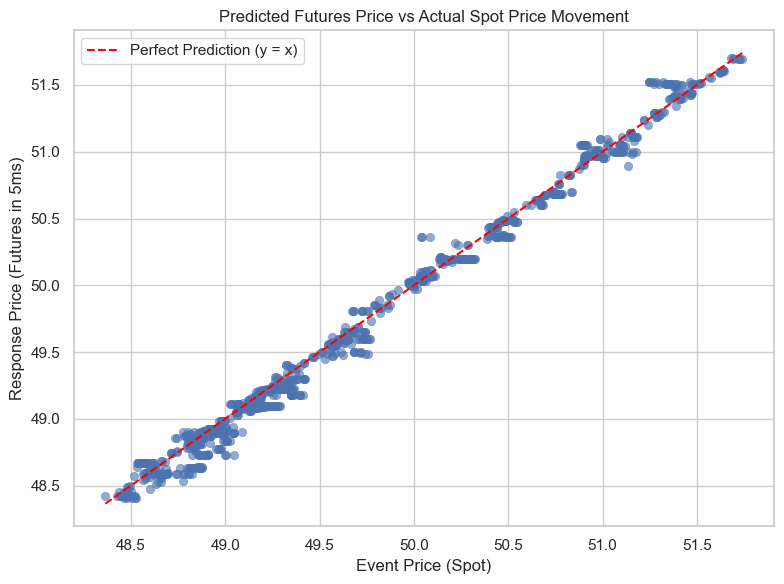

In [43]:
plt.figure(figsize=(8, 6))

# Scatter plot: actual vs predicted
sns.scatterplot(
    data=spot_to_futures,
    x='event_price',
    y='response_price',
    alpha=0.6,
    edgecolor=None
)

# Reference diagonal line
max_price = max(spot_to_futures['event_price'].max(), spot_to_futures['response_price'].max())
min_price = min(spot_to_futures['event_price'].min(), spot_to_futures['response_price'].min())
plt.plot([min_price, max_price], [min_price, max_price], color='red', linestyle='--', label='Perfect Prediction (y = x)')

plt.xlabel("Event Price (Spot)")
plt.ylabel("Response Price (Futures in 5ms)")
plt.title("Predicted Futures Price vs Actual Spot Price Movement")
plt.legend()
plt.tight_layout()
plt.show()

## Secondary Objective:
## (a) Identify whether the spot or perpetual market more often leads price discovery. Which one drives the other one most?

In [20]:
spot_leads = spot_to_futures['response_delta_bps'].abs().mean()
futures_leads = futures_to_spot['response_delta_bps'].abs().mean()

In [21]:
print(f"Average response after spot move: {spot_leads:.2f} bps")

Average response after spot move: 12.49 bps


In [22]:
print(f"Average response after futures move: {futures_leads:.2f} bps")

Average response after futures move: 14.31 bps


In [25]:
if spot_leads > futures_leads:
    print("Spot market more often leads price discovery.")
else:
    print("Futures market more often leads price discovery.")

Futures market more often leads price discovery.


## (b) Detect and characterize noise events—sudden price changes that do not affect the other market.

In [26]:
def detect_noise(responses_df, threshold_bps=1):
    return responses_df[responses_df['response_delta_bps'].abs() < threshold_bps]

noise_spot = detect_noise(spot_to_futures)
noise_futures = detect_noise(futures_to_spot)

In [27]:
print(f"Noise events after spot moves: {len(noise_spot)}")

Noise events after spot moves: 70


In [28]:
print(f"Noise events after futures moves: {len(noise_futures)}")

Noise events after futures moves: 97


In [29]:
noise_spot.head()

,event_time,event_price,response_price,response_delta_bps
41,2025-05-28 04:24:15.066000+00:00,50.990,50.9865,-0.686409
42,2025-05-28 04:24:15.066000+00:00,50.985,50.9865,0.294204
60,2025-05-28 04:33:01.155000+00:00,51.510,51.5110,0.194137
65,2025-05-28 04:33:01.156000+00:00,51.515,51.5115,-0.679414
79,2025-05-28 05:01:23.694000+00:00,50.595,50.5980,0.592944


In [30]:
noise_futures.head()

,event_time,event_price,response_price,response_delta_bps
6,2025-05-28 04:22:14.065000+00:00,51.0940,51.095,0.195718
20,2025-05-28 04:22:17.026000+00:00,51.0700,51.070,0.000000
61,2025-05-28 04:23:27.609000+00:00,51.1800,51.180,0.000000
124,2025-05-28 05:01:23.702000+00:00,50.4725,50.470,-0.495319
125,2025-05-28 05:01:23.702000+00:00,50.4725,50.470,-0.495319


## Plotting the Graph

C:\Users\ashee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ashee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


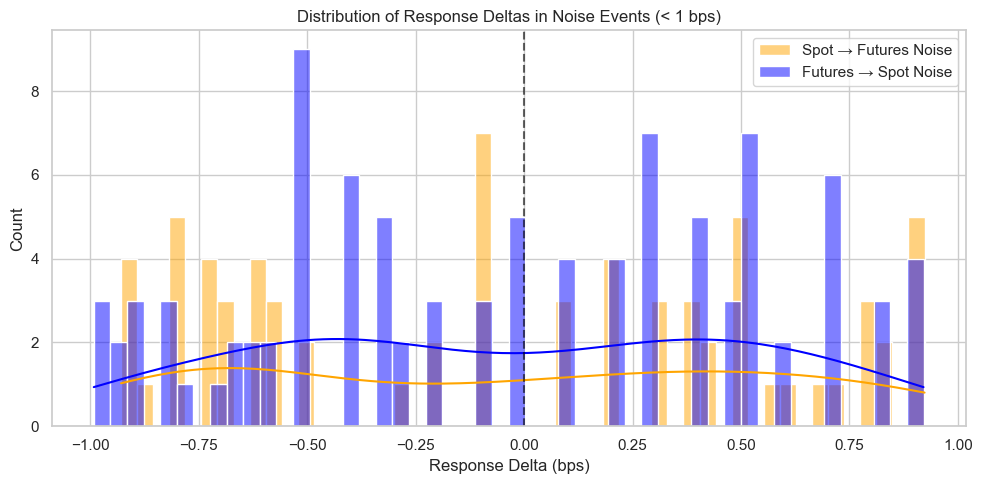

In [31]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(noise_spot['response_delta_bps'], bins=50, kde=True, color="orange", label='Spot → Futures Noise')
sns.histplot(noise_futures['response_delta_bps'], bins=50, kde=True, color="blue", label='Futures → Spot Noise')
plt.axvline(0, color='black', linestyle='--', alpha=0.6)
plt.title("Distribution of Response Deltas in Noise Events (< 1 bps)")
plt.xlabel("Response Delta (bps)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
futures_df.head()

,time,symbol,bid_price,ask_price,mid_price
1048574,2025-05-28 04:21:52.379000+00:00,TRB_USDT,50.776,50.787,50.7815
1048573,2025-05-28 04:21:52.394000+00:00,TRB_USDT,50.775,50.786,50.7805
1048572,2025-05-28 04:21:52.394000+00:00,TRB_USDT,50.775,50.787,50.7810
1048571,2025-05-28 04:21:52.398000+00:00,TRB_USDT,50.775,50.785,50.7800
1048570,2025-05-28 04:21:52.406000+00:00,TRB_USDT,50.775,50.788,50.7815


In [33]:
sudden_moves_futures.head()

,time,price_now,price_prev,delta_bps,num_trades,total_quantity,market_maker_ratio
0,2025-05-28 04:21:53.029000+00:00,50.8445,50.8075,7.282389,3,0.513,1.0
1,2025-05-28 04:21:53.029000+00:00,50.8450,50.8075,7.380800,3,0.513,1.0
2,2025-05-28 04:22:14.051000+00:00,51.0730,51.0320,8.034175,9,22.722,1.0
3,2025-05-28 04:22:14.051000+00:00,51.0930,51.0320,11.953284,9,22.722,1.0
4,2025-05-28 04:22:14.059000+00:00,51.0910,51.0540,7.247228,9,38.884,1.0


## (c) Estimating the momentum quality of the sudden price changes

In [34]:
def estimate_momentum(df, sudden_moves, trades_df, time_col='time', price_col='price_now', max_duration_ms=1000, epsilon_pct=0.01):
    momentum_data = []

    for _, row in sudden_moves.iterrows():
        t_event = row[time_col]
        price_event = row[price_col]
        direction = 1 if row['delta_bps'] > 0 else -1
        t_max = t_event + pd.Timedelta(milliseconds=max_duration_ms)

        # Price momentum calculation
        future_slice = df[(df[time_col] > t_event) & (df[time_col] <= t_max)]

        last_price = price_event
        duration_ms = 0

        for _, future_row in future_slice.iterrows():
            price_now = future_row['mid_price']
            pct_move = (price_now - price_event) / price_event * 100

            if direction * pct_move >= epsilon_pct:
                last_price = price_now
                duration_ms = (future_row[time_col] - t_event).total_seconds() * 1000
            else:
                break

        total_delta_bps = (last_price - price_event) / price_event * 10000

        # Enrich with trades during the momentum window
        trades_window = trades_df[(trades_df['time'] > t_event) & (trades_df['time'] <= t_event + pd.Timedelta(milliseconds=duration_ms))]

        total_quantity_traded = trades_window['quantity'].sum()
        num_trades_in_window = len(trades_window)

        if not trades_window.empty:
            vwap = np.average(trades_window['price'], weights=trades_window['quantity'])
            market_maker_ratio_in_window = trades_window['is_market_maker'].value_counts(normalize=True).get('t', 0)
        else:
            vwap = np.nan
            market_maker_ratio_in_window = np.nan

        momentum_data.append({
            'time': t_event,
            'initial_delta_bps': row['delta_bps'],
            'duration_ms': duration_ms,
            'total_delta_bps': total_delta_bps,
            'total_quantity_traded': total_quantity_traded,
            'num_trades_in_window': num_trades_in_window,
            'vwap': vwap,
            'market_maker_ratio_in_window': market_maker_ratio_in_window
        })

    return pd.DataFrame(momentum_data)

In [35]:
momentum_df = estimate_momentum(
    df=futures_df,
    sudden_moves=sudden_moves_futures,
    trades_df=trades_df,
    time_col='time',
    price_col='price_now'
)

In [36]:
momentum_df.head()

,time,initial_delta_bps,duration_ms,total_delta_bps,total_quantity_traded,num_trades_in_window,vwap,market_maker_ratio_in_window
0,2025-05-28 04:21:53.029000+00:00,7.282389,0.0,0.000000,0.000,0,NaN,NaN
1,2025-05-28 04:21:53.029000+00:00,7.380800,0.0,0.000000,0.000,0,NaN,NaN
2,2025-05-28 04:22:14.051000+00:00,8.034175,3.0,3.818064,10.319,5,51.009575,1.0
3,2025-05-28 04:22:14.051000+00:00,11.953284,0.0,0.000000,0.000,0,NaN,NaN
4,2025-05-28 04:22:14.059000+00:00,7.247228,0.0,0.000000,0.000,0,NaN,NaN


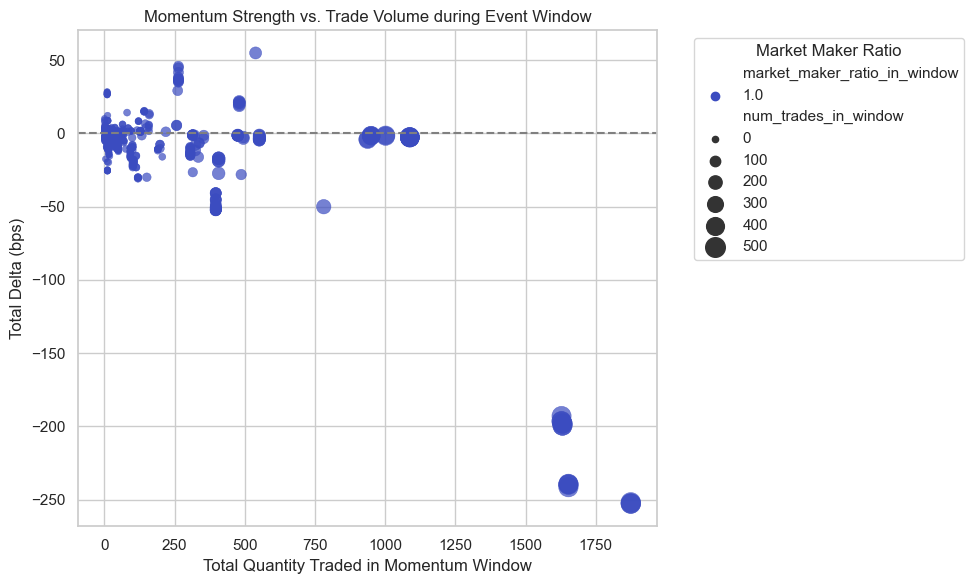

In [41]:
plot_df = momentum_df.dropna(subset=['total_delta_bps', 'total_quantity_traded'])

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=plot_df,
    x='total_quantity_traded',
    y='total_delta_bps',
    size='num_trades_in_window',
    hue='market_maker_ratio_in_window',
    palette='coolwarm',
    sizes=(20, 200),
    alpha=0.7,
    edgecolor=None
)

plt.title("Momentum Strength vs. Trade Volume during Event Window")
plt.xlabel("Total Quantity Traded in Momentum Window")
plt.ylabel("Total Delta (bps)")
plt.axhline(0, linestyle='--', color='gray')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Market Maker Ratio')
plt.tight_layout()
plt.show()

In [39]:
momentum_df.sort_values(by='duration_ms', ascending=False).head(10)

,time,initial_delta_bps,duration_ms,total_delta_bps,total_quantity_traded,num_trades_in_window,vwap,market_maker_ratio_in_window
225,2025-05-28 05:59:24.937000+00:00,-7.461796,1000.0,-199.528062,1631.339,480,49.593911,1.0
229,2025-05-28 05:59:24.938000+00:00,-9.950051,1000.0,-196.310830,1627.987,479,49.592826,1.0
220,2025-05-28 05:59:24.937000+00:00,-8.854664,1000.0,-198.161776,1631.339,480,49.593911,1.0
228,2025-05-28 05:59:24.938000+00:00,-13.432569,1000.0,-192.892086,1627.987,479,49.592826,1.0
1308,2025-05-28 10:44:20.475000+00:00,-30.147277,1000.0,-28.057304,487.243,105,50.369928,1.0
221,2025-05-28 05:59:24.937000+00:00,-8.854664,1000.0,-198.161776,1631.339,480,49.593911,1.0
222,2025-05-28 05:59:24.937000+00:00,-7.461796,1000.0,-199.528062,1631.339,480,49.593911,1.0
226,2025-05-28 05:59:24.937000+00:00,-9.252627,1000.0,-197.771338,1631.339,480,49.593911,1.0
227,2025-05-28 05:59:24.938000+00:00,-9.651549,1000.0,-196.603755,1627.987,479,49.592826,1.0
660,2025-05-28 05:59:29.029000+00:00,-17.878548,999.0,-18.622921,406.797,179,49.053664,1.0


## Exporting Important Findings to CSV

In [44]:
# Saving spot to futures prediction results
spot_to_futures.to_csv("spot_to_futures_predictions.csv", index=False)

# Saving futures to spot prediction results
futures_to_spot.to_csv("futures_to_spot_predictions.csv", index=False)

# Saving noise events after spot moves
noise_spot.to_csv("noise_spot_events.csv", index=False)

# Saving noise events after futures moves
noise_futures.to_csv("noise_futures_events.csv", index=False)

# Saving momentum estimation results
momentum_df.to_csv("momentum_estimation_results.csv", index=False)